# Project planning

## Tool-based evaluation of CWE Pillars
Analysis begins with a high-level view of the CWE pillars and their descendents (children) over the last decade.
The interconnectedness of weakesses are maintained in the datastore, so we can reference the children of CWEs.

We first define the years to evaluate, then we gather the data from each CWE pillar for each year into a dictionary.

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pprint import pprint
sys.path.append(os.path.abspath('..'))
from cwei import CWEi

start_year = 2013
stop_year = 2024
years = list(range(start_year, stop_year))

cwei = CWEi()

annual_counts = {p: [] for p in cwei.pillars}
    
for p in cwei.pillars:
    print(f"{p} ", end="")
    children = cwei.get_child_cwes(p)
    everyone = [p] + children
    
    for year in range(start_year, stop_year):
        cve_counts = cwei.get_cve_count_for_cwes(everyone, str(year))
        total_count = sum(cve_counts.values())
        annual_counts[p].append(total_count)

284 435 664 682 691 693 697 703 707 710 

We will utilize a pandas dataframe for our analysis.

In [2]:
import pandas as pd
df = pd.DataFrame(annual_counts, index=years)
df

,284,435,664,682,691,693,697,703,707,710
2013,107,0,1044,15,60,111,0,0,1209,5
2014,183,0,1378,14,39,244,0,2,1938,15
2015,190,0,1818,18,49,240,2,1,1430,10
2016,502,0,2387,80,59,103,0,0,1200,84
2017,1210,5,6284,318,312,541,1,35,3370,349
2018,1362,13,6328,779,280,750,6,31,4336,344
2019,1838,15,6346,299,271,1063,4,108,4523,241
2020,2304,57,5747,255,335,954,12,129,4251,175
2021,1984,39,5834,271,370,894,24,135,4198,291
2022,2240,29,6978,284,479,952,20,154,5328,293


## Several views of pillar-level evaluation

First, we consider the raw totals over the years and see that two pillars (664 and 707) encapsulate CWE classes associated with the vast majority of CVEs for the last 10 years.
However, the magnitude of vulnerabilities that are mapped to those two pillars might obscure the changes in vulnerability counts for other CWE classes.

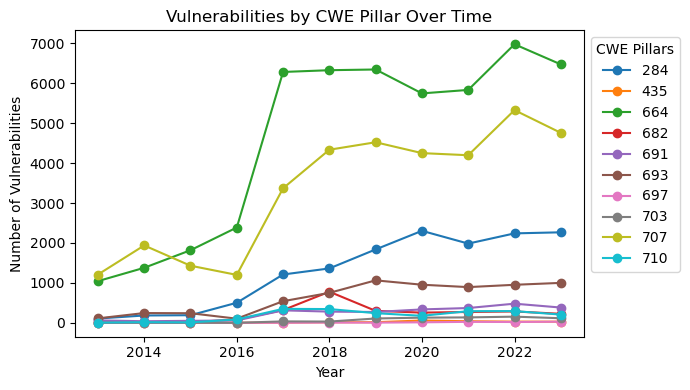

In [3]:
import matplotlib.pyplot as plt

# Plotting vulnerabilities for all pillars over the years
df.plot(kind='line', figsize=(7, 4), marker='o')

# Add labels and title
plt.title('Vulnerabilities by CWE Pillar Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Vulnerabilities')

# Move the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='CWE Pillars')

# Make sure everything fits well
plt.tight_layout()
# with PdfPages('cwe-pillars.pdf') as pdf:
#         pdf.savefig()
# plt.savefig('cwe-pillars.png')
# Show the plot
plt.show()

## Visualizing change without regard to scale
By normalizing the CVE counts per pillar over the years, we can visualize the true change without considering the number of vulnerabilities.
At this level, we can see that CWE-693 is on the rise.
However, we have no way of understanding if the number of vulnerabilities tripled (from one to three) or merely doubled (from five hundred to one thousand).
It appears that the number of vulnerabilities will need to be considered.

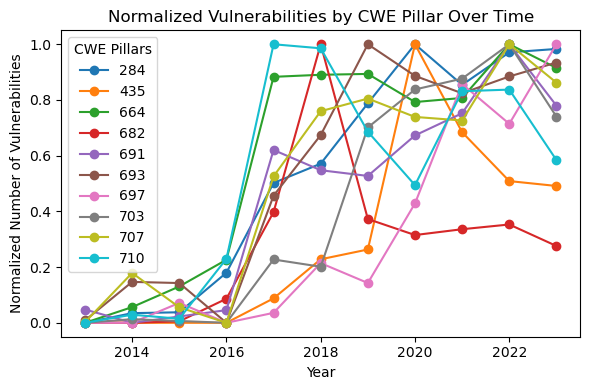

In [4]:
# Min-Max normalization of the DataFrame
df_normalized = (df - df.min()) / (df.max() - df.min())

# Plot the normalized data
df_normalized.plot(kind='line', figsize=(6, 4), marker='o')

# Add labels and title
plt.title('Normalized Vulnerabilities by CWE Pillar Over Time')
plt.xlabel('Year')
plt.ylabel('Normalized Number of Vulnerabilities')
plt.legend(title='CWE Pillars')

# Show the plot
plt.tight_layout()
# with PdfPages('cwe-norm-pillars.pdf') as pdf:
#     pdf.savefig()
plt.show()

## Comparison of change



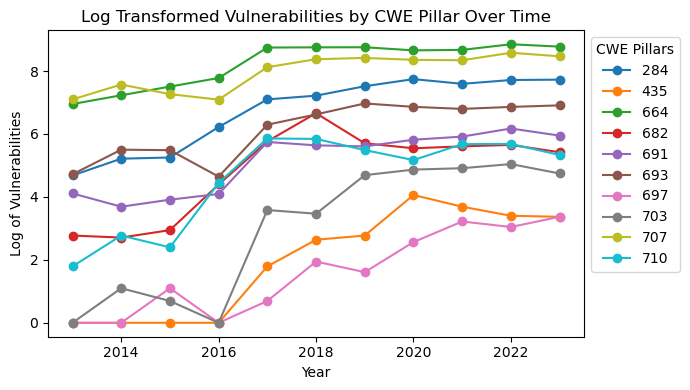

In [5]:
import numpy as np

# Logarithmic transformation with base 10 (you can change the base if needed)
df_log = np.log(df + 1)  # Log transformation to handle zeros

# Plot the log-transformed data
df_log.plot(kind='line', figsize=(7, 4), marker='o')

# Add labels and title
plt.title('Log Transformed Vulnerabilities by CWE Pillar Over Time')
plt.xlabel('Year')
plt.ylabel('Log of Vulnerabilities')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='CWE Pillars')
# Show the plot
plt.tight_layout()
# with PdfPages('cwe-log-pillars.pdf') as pdf:
#     pdf.savefig()
# plt.savefig('cwe-log-pillars.png')
plt.show()

## Finding where to focus
By performing a linear regression on the the plots for log transformations of each pillar, we can find the pillar that is experiencing the most rapid growth.


In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Prepare the years as a 2D array for linear regression
years = np.array(df_normalized.index).reshape(-1, 1)

# Dictionary to store the slopes for each CWE
slopes = {}

# Perform linear regression for each CWE
for column in df_normalized.columns:
    # Fit the linear regression model
    model = LinearRegression()
    model.fit(years, df_normalized[column])
    
    # Store the slope (coefficient) of the trend line
    slopes[column] = model.coef_[0]

# Find the CWE with the sharpest upward trend
sharpest_cwe = max(slopes, key=slopes.get)
sharpest_slope = slopes[sharpest_cwe]

print(f"The CWE with the sharpest upward trend is {sharpest_cwe} with a slope of {sharpest_slope:.2f}")
slopes

The CWE with the sharpest upward trend is 284 with a slope of 0.12


{'284': 0.1185169859726073,
 '435': 0.07926634768740035,
 '664': 0.10475840303949509,
 '682': 0.038265002970885344,
 '691': 0.1000826446280992,
 '693': 0.1085511363636364,
 '697': 0.10162337662337666,
 '703': 0.11280991735537194,
 '707': 0.10321749471458777,
 '710': 0.08017970401691334}

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Prepare the years as a 2D array for linear regression
years = np.array(df_log.index).reshape(-1, 1)
slopes = {}

# Perform linear regression for each CWE
for column in df_log.columns:
    model = LinearRegression()
    model.fit(years, df_log[column])
    slopes[column] = model.coef_[0]

sharpest_cwe = max(slopes, key=slopes.get)
sharpest_slope = slopes[sharpest_cwe]

print(f"The CWE with the sharpest upward trend is {sharpest_cwe} with a slope of {sharpest_slope:.2f}")
slopes

The CWE with the sharpest upward trend is 703 with a slope of 0.57


{'284': 0.3246104400029284,
 '435': 0.46008747557297625,
 '664': 0.18972015307274642,
 '682': 0.32037840467911427,
 '691': 0.2585736496996782,
 '693': 0.23118138380028905,
 '697': 0.3765595359656689,
 '703': 0.5727757537730305,
 '707': 0.15403797374126194,
 '710': 0.36610914943418926}

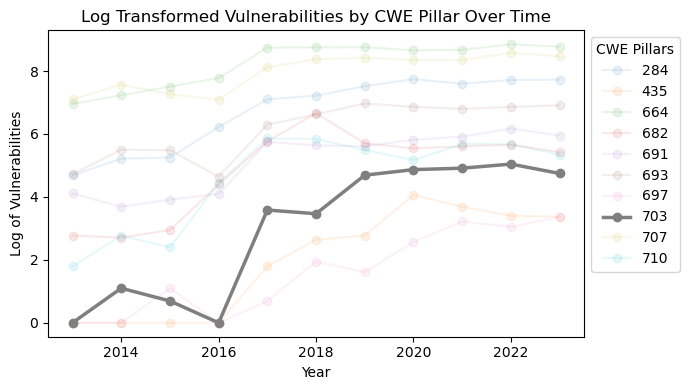

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Logarithmic transformation with base 10 (you can change the base if needed)
df_log = np.log(df + 1)  # Log transformation to handle zeros

# Plot the log-transformed data
ax = df_log.plot(kind='line', figsize=(7, 4), marker='o')

# Highlight one line (e.g., the first column)
highlight_column = '703'  # Replace with the column name you want to highlight

for line, label in zip(ax.get_lines(), df_log.columns):
    if label == highlight_column:
        line.set_alpha(1.0)  # Fully visible
        line.set_linewidth(2.5)  # Optional: Make the highlighted line thicker
    else:
        line.set_alpha(0.1)  # Dim other lines

# Add labels and title
plt.title('Log Transformed Vulnerabilities by CWE Pillar Over Time')
plt.xlabel('Year')
plt.ylabel('Log of Vulnerabilities')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='CWE Pillars')

# Show the plot
plt.tight_layout()
# with PdfPages('cwe-pillar-703.pdf') as pdf:
#     pdf.savefig()
# plt.savefig('cwe-pillar-703.png')
plt.show()

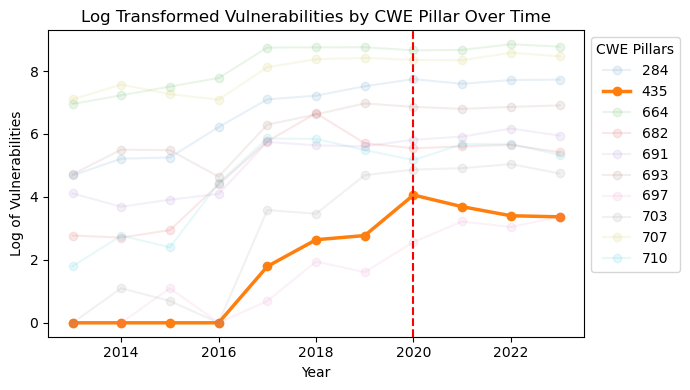

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Logarithmic transformation with base 10 (you can change the base if needed)
df_log = np.log(df + 1)  # Log transformation to handle zeros

# Plot the log-transformed data
ax = df_log.plot(kind='line', figsize=(7, 4), marker='o')

# Highlight one line (e.g., the first column)
highlight_column = '435'  # Replace with the column name you want to highlight


# # Split the data into before and after 2020
# pre_2020 = df_log.loc[:'2020', highlight_column]
# post_2020 = df_log.loc['2020':, highlight_column]

# # Plot the highlighted column with two different alpha values
# ax.plot(pre_2020.index, pre_2020.values, label=None, 
#         linewidth=2.5, alpha=1.0, color='orange')  # Fully visible before 2020
# ax.plot(post_2020.index, post_2020.values, label=None, 
#         linewidth=2.5, alpha=1.0, color='white')  # Semi-transparent after 2020

for line, label in zip(ax.get_lines(), df_log.columns):
    if label == highlight_column:
        line.set_alpha(1)  # Fully visible
        line.set_linewidth(2.5)  # Optional: Make the highlighted line thicker
    else:
        line.set_alpha(0.1)  # Dim other lines

plt.axvline(x=2020, color='red', linestyle='--', linewidth=1.5, label=None)
# Add labels and title
plt.title('Log Transformed Vulnerabilities by CWE Pillar Over Time')
plt.xlabel('Year')
plt.ylabel('Log of Vulnerabilities')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='CWE Pillars')

# Show the plot
plt.tight_layout()
# with PdfPages('cwe-pillar-435.pdf') as pdf:
#     pdf.savefig()
# plt.savefig('cwe-pillar-435.png')
plt.show()

# Narrowing the scope to a single pillar
## CWE-703: Improper Check or Handling of Exceptional Conditions
To understand the specific areas of a vulnerability branch have increased vulnerabilities, we identify the descendant CWEs with a surge of associated vulnerabilities.

In [10]:
cwe_id = '703'
start_year = 2013
stop_year = 2024
years = list(range(start_year, stop_year))

depth = cwei.get_cwe_depth(cwe_id)

sub_branches = cwei.get_child_cwes(int(cwe_id), max_depth = 1) # Get the children of the parent CWE, but not other descendants
sub_branches.append(cwe_id)  # Add the parent CWE to the list (since vulnerabilities are mapped there too)
totals = {c: [] for c in sub_branches}

for year in range(start_year, stop_year):
    for c in sub_branches:
        if (c != cwe_id):
            children = cwei.get_child_cwes(c)
            everyone = [c] + children
        else:
            everyone = [c] 
        cve_counts = cwei.get_cve_count_for_cwes(everyone, str(year))
        # print the total count by totalling the counts of the pillar and its children
        # to do this we will bypass the get_total_cve_count_for_cwes method and instead sum the counts
        total_count = sum(cve_counts.values())
        totals[c].append(total_count)

pprint(totals)

df_single = pd.DataFrame(totals, index=years)
# df_single

{'1384': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 '703': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 '754': [0, 1, 1, 0, 19, 13, 43, 52, 61, 68, 55],
 '755': [0, 1, 0, 0, 16, 18, 65, 77, 74, 86, 59]}


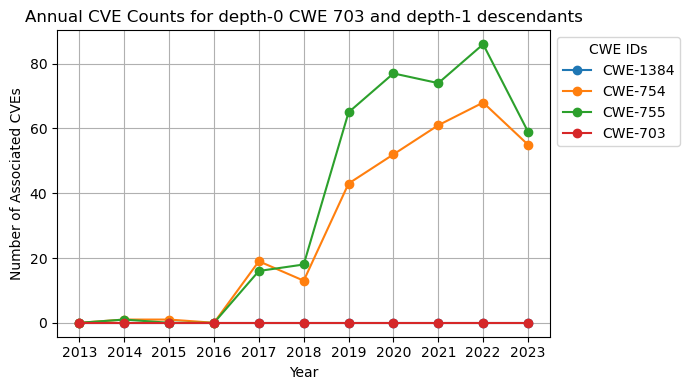

In [11]:
# Create the line chart
plt.figure(figsize=(7, 4))

for cwe_id, counts in df_single.items():
    plt.plot(years, counts, marker='o', label=f'CWE-{cwe_id}')

plt.xlabel('Year')
plt.ylabel('Number of Associated CVEs')
plt.title(f"Annual CVE Counts for depth-{depth} CWE {cwe_id} and depth-{depth+1} descendants")
plt.xticks(years)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1),title='CWE IDs')
plt.grid()
plt.tight_layout()
plt.show()

# Re-visit the analysis
## CWE-284: Improper Access Control
It appears that CWE-703 is not very popular, with less than 80 total vulnerabilities for the the two most prominent descendants in the last year.
For that reason, let's take a look at the pillar with the second steepest slope of normalized values: **CWE-284: Improper Access Control**.

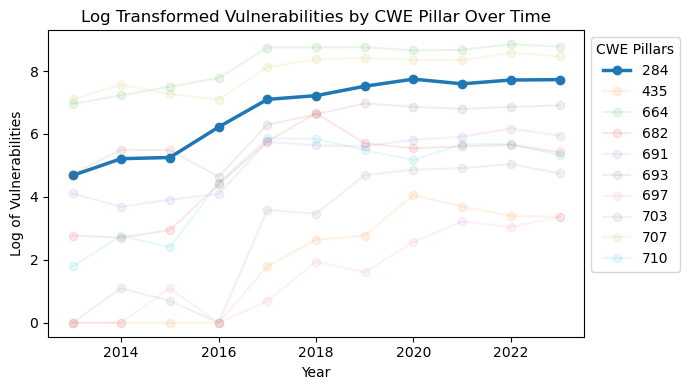

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Logarithmic transformation with base 10 (you can change the base if needed)
df_log = np.log(df + 1)  # Log transformation to handle zeros

# Plot the log-transformed data
ax = df_log.plot(kind='line', figsize=(7, 4), marker='o')

# Highlight one line (e.g., the first column)
highlight_column = '284'  # Replace with the column name you want to highlight

for line, label in zip(ax.get_lines(), df_log.columns):
    if label == highlight_column:
        line.set_alpha(1.0)  # Fully visible
        line.set_linewidth(2.5)  # Optional: Make the highlighted line thicker
    else:
        line.set_alpha(0.1)  # Dim other lines

# Add labels and title
plt.title('Log Transformed Vulnerabilities by CWE Pillar Over Time')
plt.xlabel('Year')
plt.ylabel('Log of Vulnerabilities')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='CWE Pillars')

# Show the plot
plt.tight_layout()
# with PdfPages('cwe-pillar-log-284.pdf') as pdf:
#     pdf.savefig()
# plt.savefig('cwe-pillar-log-284.png')
plt.show()

In [13]:
cwe_id = '284'
start_year = 2013
stop_year = 2024
years = list(range(start_year, stop_year))

depth = cwei.get_cwe_depth(cwe_id)

sub_branches = cwei.get_child_cwes(int(cwe_id), max_depth = 1) # Get the children of the parent CWE, but not other descendants
sub_branches.append(cwe_id)  # Add the parent CWE to the list (since vulnerabilities are mapped there too)
totals = {c: [] for c in sub_branches}

for year in range(start_year, stop_year):
    for c in sub_branches:   
        if (c != cwe_id):
            children = cwei.get_child_cwes(c)
            everyone = [c] + children
        else:
            everyone = [c] 
        cve_counts = cwei.get_cve_count_for_cwes(everyone, str(year))
        total_count = sum(cve_counts.values())
        totals[c].append(total_count)

# pprint(totals)

df_single = pd.DataFrame(totals, index=years)
df_single

,1191,1220,1224,1231,1233,1242,1252,1257,1259,1260,...,1323,1334,269,282,285,286,287,749,923,284
2013,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,7,0,96,0,0,3
2014,0,0,0,0,0,0,0,0,0,0,...,0,0,15,0,3,0,144,0,1,20
2015,0,0,0,0,0,0,0,0,0,0,...,0,0,7,0,3,0,37,0,0,143
2016,0,0,0,0,0,0,0,0,0,0,...,0,0,10,0,22,0,72,1,1,396
2017,0,0,0,0,0,0,0,0,0,0,...,0,0,94,0,233,0,618,1,2,262
2018,0,0,0,0,0,0,0,0,0,0,...,0,0,112,0,437,0,767,2,1,43
2019,0,0,0,0,0,0,0,0,0,0,...,0,0,142,0,709,0,924,2,1,60
2020,0,0,0,0,0,0,0,0,0,0,...,0,0,234,0,879,0,1190,0,0,1
2021,0,0,0,0,0,0,0,0,0,0,...,0,0,284,0,840,0,860,0,0,0
2022,0,0,0,0,0,0,0,0,0,0,...,0,0,168,0,1046,0,1026,0,0,0


This CWE pillar has many children nodes and there are many years where the children nodes do not have any reported vulnerabilities.
Let's trim out those empty child nodes to maintain a focus on the child nodes with the most vulnerabilities.

In [14]:
df_single = df_single.loc[:, (df_single != 0).any(axis=0)]
df_single
non_zero_counts = (df_single != 0).sum(axis=0)

# Sort columns based on non-zero counts in descending order and select the top 8
top_columns = non_zero_counts.sort_values(ascending=False).head(8).index

# Filter the dataframe to keep only these top 8 columns
df_trimmed = df_single[top_columns]

## Consider a single branch (CWE pillar and descendants)
Here we repeat the initial investigation model, but instead of starting with the root node and considering all the children of the root (the ten CWE pillars), we start with a single pillar as the root and plot the cumulative vulnerability counts associated with it's direct descendants.

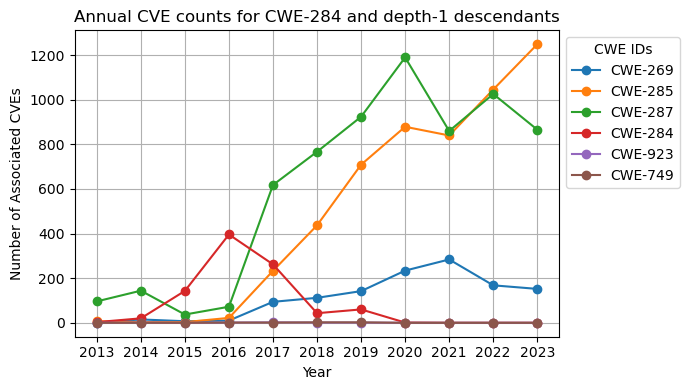

In [15]:
# Create the line chart
plt.figure(figsize=(7, 4))

for label_id, counts in df_trimmed.items():
    plt.plot(years, counts, marker='o', label=f'CWE-{label_id}')

plt.xlabel('Year')
plt.ylabel('Number of Associated CVEs')
plt.title(f"Annual CVE counts for CWE-{cwe_id} and depth-{depth+1} descendants")
plt.xticks(years)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1),title='CWE IDs')
plt.grid()
plt.tight_layout()
# plt.savefig('pillar284.png')
plt.show()

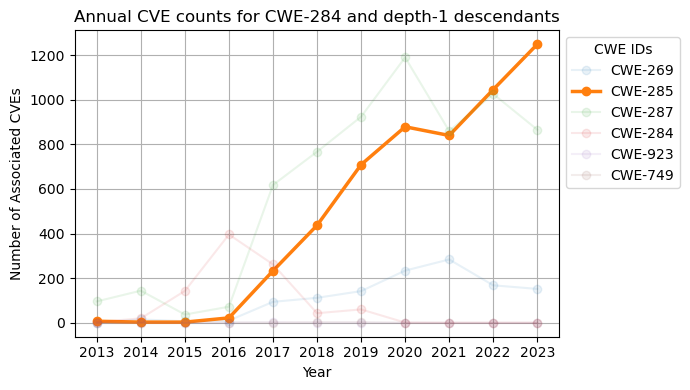

In [16]:
# Create the line chart
plt.figure(figsize=(7, 4))

# Specify the CWE ID to highlight
highlight_cwe_id = '285'  # Replace with the CWE ID you want to highlight

for cwe_label, counts in df_trimmed.items():
    if str(cwe_label) == highlight_cwe_id:  # Highlight the specified CWE ID
        plt.plot(years, counts, marker='o', label=f'CWE-{cwe_label}', alpha=1.0, linewidth=2.5)
    else:  # Dim other lines
        plt.plot(years, counts, marker='o', label=f'CWE-{cwe_label}', alpha=0.1)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Associated CVEs')
plt.title(f"Annual CVE counts for CWE-{cwe_id} and depth-{depth+1} descendants")
plt.xticks(years)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='CWE IDs')

# Add grid and adjust layout
plt.grid()
plt.tight_layout()
# with PdfPages('cwe-284-children.pdf') as pdf:
#     pdf.savefig()
# plt.savefig('cwe-284-children.png')
plt.show()


# Conclusion
Examining the CWE pillars revealed some interesting trends over the years.
Considering a few pillars and their descendant CWEs revealed that the the aggregate totals might just be showing a few popular decendants.
The slope of the weaknesses at differing levels of abstraction is an objective measure of reported vulnerabilities that informs the planning stage of the software development lifecycle.